## Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score

import torch
import torchvision
from torchvision.utils import make_grid


## Get the datasets

In [2]:
from torchvision import datasets, transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.CIFAR10(root = r"c:\path", download=True, train=True, transform=transform)
test_data = datasets.CIFAR10(root = r"c:\path", download=True, train=False, transform=transform)
classes = train_data.classes

Files already downloaded and verified
Files already downloaded and verified


## Explore Datasets

In [3]:
print(train_data)
print(test_data)
print(train_data.classes)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: c:\path
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: c:\path
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


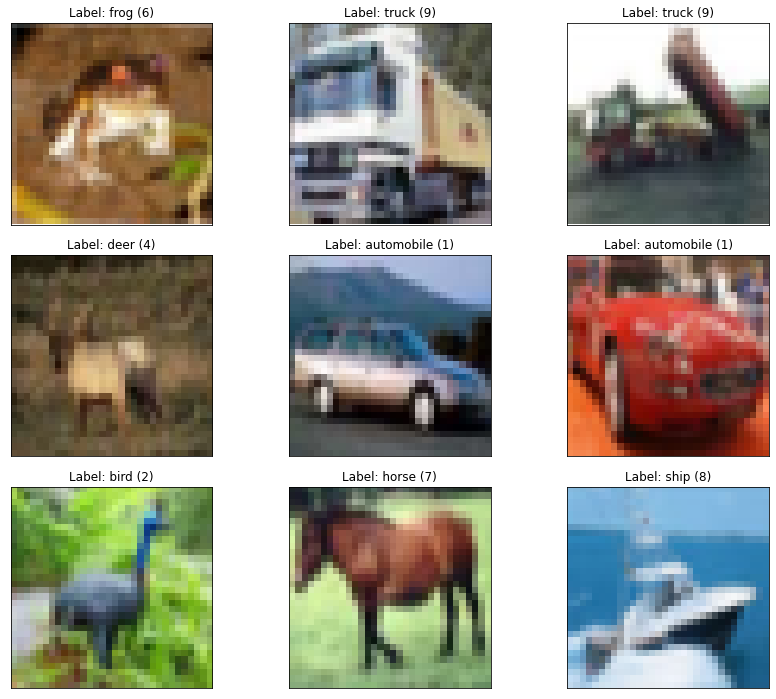

In [4]:
def show_examples(images, start, end, num_row, num_col):
  fig = plt.figure(figsize=(12, 10))
  for i in range(start, end):
    label = images[i][1]
    img = images[i][0] / 2 + 0.5 # unnormalize images
    title = 'Label: {} ({})'.format(classes[label], str(label))
    plt.subplot(num_row, num_col,i - start +1)
    plt.tight_layout()
    plt.imshow(img.permute(1, 2, 0))
    plt.title(title)
    plt.xticks([])
    plt.yticks([])

def show_example(img, label):
  title = 'Label: {} ({})'.format(classes[label], str(label))
  plt.title(title)
  plt.imshow(img.permute(1, 2, 0))

show_examples(train_data, 0, 9, 3, 3)

## Preprocess Input

In [5]:
from torch.utils.data.dataloader import DataLoader

batch_size = 8

# load data into batch
train_loader = DataLoader(train_data, batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_data, batch_size * 2, num_workers=2, pin_memory=True)

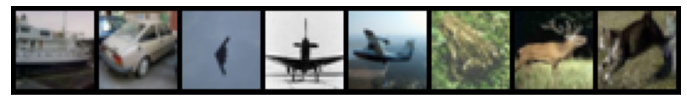

In [6]:
def show_batch(dl):
    for images, labels in dl:
      images = images / 2 + 0.5
      fig, ax = plt.subplots(figsize=(12, 6))
      ax.set_xticks([]); ax.set_yticks([])
      ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
      break

show_batch(train_loader)

## Define the Model

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net()

In [8]:
import torch.optim as optim

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Training the Model

In [9]:
for epoch in range(10):
  running_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss
    if i % 1600 == 1599:    # print every 1600 mini-batches
          print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 2000))
          running_loss = 0.0

print("Finished Training")

[1,  1600] loss: 1.777
[1,  3200] loss: 1.544
[1,  4800] loss: 1.384
[2,  1600] loss: 1.226
[2,  3200] loss: 1.152
[2,  4800] loss: 1.127
[3,  1600] loss: 1.048
[3,  3200] loss: 1.024
[3,  4800] loss: 1.006
[4,  1600] loss: 0.941
[4,  3200] loss: 0.943
[4,  4800] loss: 0.933
[5,  1600] loss: 0.859
[5,  3200] loss: 0.877
[5,  4800] loss: 0.869
[6,  1600] loss: 0.799
[6,  3200] loss: 0.823
[6,  4800] loss: 0.829
[7,  1600] loss: 0.759
[7,  3200] loss: 0.783
[7,  4800] loss: 0.778
[8,  1600] loss: 0.718
[8,  3200] loss: 0.728
[8,  4800] loss: 0.734
[9,  1600] loss: 0.683
[9,  3200] loss: 0.700
[9,  4800] loss: 0.708
[10,  1600] loss: 0.646
[10,  3200] loss: 0.655
[10,  4800] loss: 0.680
Finished Training


In [10]:
# Save trained model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## Evaluate the Model

In [11]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


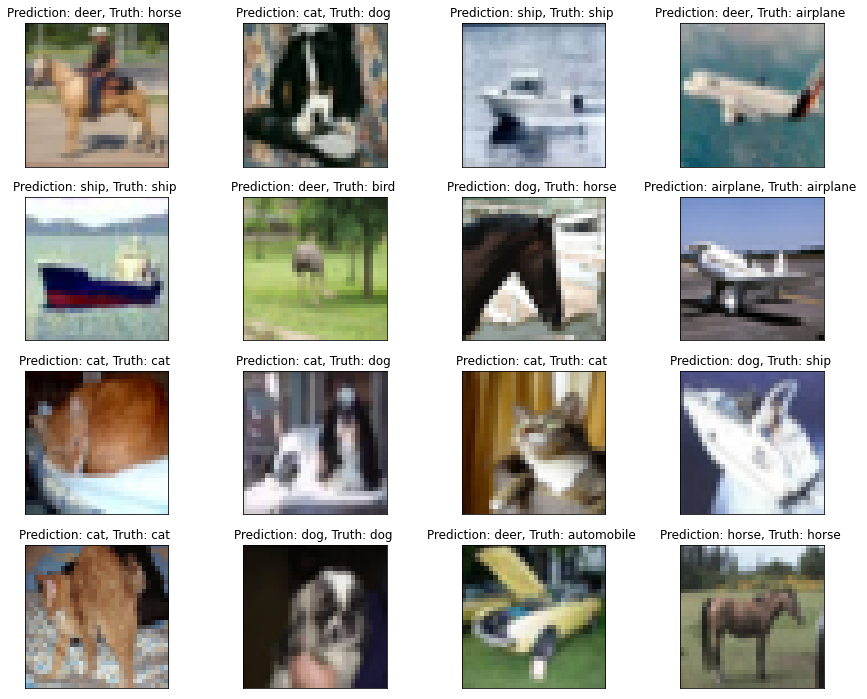

In [14]:
def show_predictions(images, predictions, labels, start, end, num_row, num_col):
  fig = plt.figure(figsize=(12, 10))
  for i in range(start, end):
    label = int(labels[i])
    title = 'Prediction: {}, Truth: {} '.format(classes[predictions[i]],classes[label])
    plt.subplot(num_row, num_col,i - start +1)
    plt.tight_layout()
    img = images[i] / 2 + 0.5
    plt.imshow(img.permute(1, 2, 0))
    plt.title(title)
    plt.xticks([])
    plt.yticks([])

show_predictions(images, predicted, labels, 0, 16, 4, 4)

In [13]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 63 %
